Script to analyze the results on real datasets. This includes plotting the trees, gene expression analysis, examining optimized parameters and mutations.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pygraphviz as pgv
import seaborn as sns
import os
import json

import dendropy
from dendropy.calculate import treecompare

from src_python.utils import load_config_and_set_random_seed, path_len_dist, leaf_dist_mat
from src_python.cell_tree import CellTree

In [2]:
study_nums = ["mm16", "mm34"] # cancer sample ids to analyze
np.random.seed(0)
n_rounds = 2 # Number of rounds of parameter and tree optimization
use_summary_statistics = True # If True uses summary files instead of raw data files

primary_cells = {}
cell_names = {}
expression_counts_scaled = {}

for study_num in study_nums: # Primary tumor cells
    if study_num == "mm34":
        cell_indices = ["SRR6710302", "SRR6710303", "SRR6710304", "SRR6710305", "SRR6710306", "SRR6710307", "SRR6710308", "SRR6710309", "SRR6710310", "SRR6710311", "SRR6710312", "SRR6710313", "SRR6710314", "SRR6710315", "SRR6710316", "SRR6710317", "SRR6710318", "SRR6710319", "SRR6710320", "SRR6710321", "SRR6710322", "SRR6710323", "SRR6710324", "SRR6710325", "SRR6710326", "SRR6710327", "SRR6710328", "SRR6710329", "SRR6710330", "SRR6710331", "SRR6710332", "SRR6710333", "SRR6710334", "SRR6710335", "SRR6710336", "SRR6710337", "SRR6710338", "SRR6710339", "SRR6710340", "SRR6710341", "SRR6710342", "SRR6710343", "SRR6710344", "SRR6710345", "SRR6710346", "SRR6710347", "SRR6710348", "SRR6710349", "SRR6710350", "SRR6710351", "SRR6710352", "SRR6710353", "SRR6710354", "SRR6710355", "SRR6710356", "SRR6710357", "SRR6710358", "SRR6710359", "SRR6710360", "SRR6710361", "SRR6710362", "SRR6710363", "SRR6710364", "SRR6710365", "SRR6710366"]

    if study_num == "mm16":
        cell_indices = ["SRR6710256", "SRR6710257", "SRR6710258", "SRR6710259", "SRR6710260", "SRR6710261", "SRR6710262", "SRR6710263", "SRR6710264", "SRR6710265", "SRR6710266", "SRR6710267", "SRR6710268", "SRR6710269", "SRR6710270", "SRR6710271", "SRR6710272", "SRR6710273", "SRR6710274", "SRR6710275", "SRR6710276", "SRR6710277", "SRR6710278"]

    ref = np.array(pd.read_csv(os.path.join(f"../data/input_data/{study_num}", "ref.csv")))
    cell_names[study_num] = list(ref[:,0])
    primary_cells[study_num] = [cell_names[study_num].index(item) for item in cell_indices if item in cell_names[study_num]]

    expression_counts = pd.read_csv(rf"../data/input_data/{study_num}/gene_expression_counts.csv", index_col=0)
    normalized_counts = expression_counts.div(expression_counts.sum(axis=1), axis=0) * 1e5
    expression_counts_scaled[study_num] = np.log1p(normalized_counts)

Plot the trees

In [3]:
def plot_trees(inpath, test, plot_mutations=False, round=0, pc=[], model="", cell_ids=[]):

    path_parent = os.path.join(inpath, f"{model}_parent_vec", f"{model}_parent_vec{round}{test}.txt")
    path_mut_loc = os.path.join(inpath, f"{model}_mutation_location", f"{model}_mutation_location{round}{test}.txt")
    path_selected = os.path.join(inpath, f"{model}_selected_loci", f"{model}_selected_loci{round}{test}.txt")

    parent_vec = np.loadtxt(path_parent, dtype=int)
    if os.path.exists(path_mut_loc) == False:
        mut_locs = []
        selected_mutations = []
    else:
        mut_locs = np.loadtxt(path_mut_loc, dtype=int)
        selected_mutations = np.loadtxt(path_selected, dtype=int)

    n_cells = int(((len(parent_vec)+1)/2))

    ct = CellTree(n_cells=n_cells, n_mut=len(selected_mutations))
    ct.use_parent_vec(parent_vec)

    if plot_mutations:
        ct.mut_loc = mut_locs
        graph = ct.to_graphviz()
        graph.render(os.path.join(inpath, f"{model}_ct_trees", f"ct_tree{round}{test}"), format="png", cleanup=True)

    ct.mut_loc = []
    graph_branches = ct.to_graphviz()
    for n in range(n_cells):
        if n in pc:
            graph_branches.node(str(n), label=cell_ids[n], shape="circle", style="filled", color="red")
        else:
            graph_branches.node(str(n), label=cell_ids[n], shape="circle", style="filled", color="blue") # metastasis

    graph_branches.render(os.path.join(inpath, f"{model}_ct_trees", f"ct_tree{round}{test}_branches"), format="svg", cleanup=True)

for study_num in study_nums:
    path = rf"../data/results/{study_num}/sciterna"
    for j in range(2):
        plot_trees(path, "r0", plot_mutations=True, round=f"_{j}", pc = primary_cells[study_num], model="sciterna", cell_ids=cell_names[study_num])

    model = "sclineager"
    plot_trees(rf"../data/results/{study_num}/sclineager", "", plot_mutations=False, round = "", pc = primary_cells[study_num], model="sclineager", cell_ids=cell_names[study_num])
    plot_trees(rf"../data/results/{study_num}/dendro", "", plot_mutations=False, round = "", pc = primary_cells[study_num], model="dendro", cell_ids=cell_names[study_num])
    plot_trees(rf"../data/results/{study_num}/phylinsic", "", plot_mutations=False, round = "", pc = primary_cells[study_num], model="phylinsic", cell_ids=cell_names[study_num])

KeyboardInterrupt: 

In [29]:
def plot_consensus_tree(parent_vector, path, study_num, support_thresholds=None, cell_ids=[]):

    n_cells = int((len(parent_vector) + 1) / 2)
    ct = CellTree(n_cells=n_cells, n_mut=0)
    ct.use_parent_vec(parent_vector)
    ct.mut_loc = []

    graph_branches = ct.to_graphviz()

    for node_id in range(len(parent_vector)):
        is_leaf = node_id < n_cells
        node_shape = "circle"
        node_style = "filled"

        if is_leaf:
            border_color = "red" if node_id in primary_cells[study_num] else "blue"
            fillcolor = "red" if node_id in primary_cells[study_num] else "blue"

            graph_branches.node(
                str(node_id),
                label= cell_ids[node_id],
                shape=node_shape,
                style=node_style,
                fillcolor=fillcolor,
                color=border_color,
                penwidth="4"
            )
        else:
            fillcolor = "lightgrey"
            penwidth = 1

            max_support = np.max(list(support_thresholds.values()))
            if support_thresholds:
                support = support_thresholds.get(str(node_id), 0.0)

                penwidth = 20 * support/max_support

            graph_branches.node(
                str(node_id),
                shape=node_shape,
                style=node_style,
                fillcolor=fillcolor,
                color="black",
                penwidth=str(penwidth)
            )

    else:
        graph_branches.render(os.path.join(path, f"sciterna_consensus_tree_{study_num}"), format="svg", cleanup=True)
    return graph_branches

graphs = {}
consensus_parent_vec = {}
for study_num in study_nums:
    path_bootstrap = rf"../data/results/{study_num}/sciterna_bootstrap"
    consensus_parent_vec[study_num] = np.loadtxt(os.path.join(path_bootstrap, "sciterna_consensus_parent_vec","sciterna_parent_vec_1r.txt"), dtype=int)

    with open(os.path.join(path_bootstrap, "sciterna_consensus_parent_vec", "sciterna_support_values_1r.json"), "r") as f:
        support_values = json.load(f)

    graph = plot_consensus_tree(consensus_parent_vec[study_num], path_bootstrap, study_num, support_thresholds=support_values, cell_ids=cell_names[study_num])
    graphs[study_num] = graph

In [5]:
def get_node_positions(dot):
    """Get x-coordinates of all nodes from Graphviz layout."""
    A = pgv.AGraph(string=dot.source if hasattr(dot, 'source') else dot)
    A.layout(prog="dot")
    positions = {}
    for node in A.nodes():
        name = node.get_name()
        if not name.isdigit():
            continue
        pos = node.attr.get('pos')
        if pos:
            x = float(pos.split(',')[0])
            positions[int(name)] = x
    return positions

def dfs_left_to_right(graph, root, n_cells, positions):

    leaf_order = []

    def dfs(node):
        children = graph.get(node, [])
        # Sort children by x-position
        children_sorted = sorted(children, key=lambda x: positions.get(x, float("inf")))
        if not children:
            if node < n_cells:  # leaf node condition
                leaf_order.append(node)
            return
        for child in children_sorted:
            dfs(child)

    dfs(root)
    return leaf_order

# Build adjacency list from parent vector
def build_adj_list(parent_vec):
    from collections import defaultdict
    adj = defaultdict(list)
    for child, parent in enumerate(parent_vec):
        if parent != -1:
            adj[parent].append(child)
    return adj

leaf_orders = {}
for study_num in study_nums:
    positions = get_node_positions(graphs[study_num])
    adj_list = build_adj_list(consensus_parent_vec[study_num])
    root = np.where(np.array(consensus_parent_vec[study_num]) == -1)[0][0]

    leaf_orders[study_num] = dfs_left_to_right(adj_list, root, len(cell_names[study_num]), positions)

Gene expression analysis

<Figure size 4000x2000 with 0 Axes>

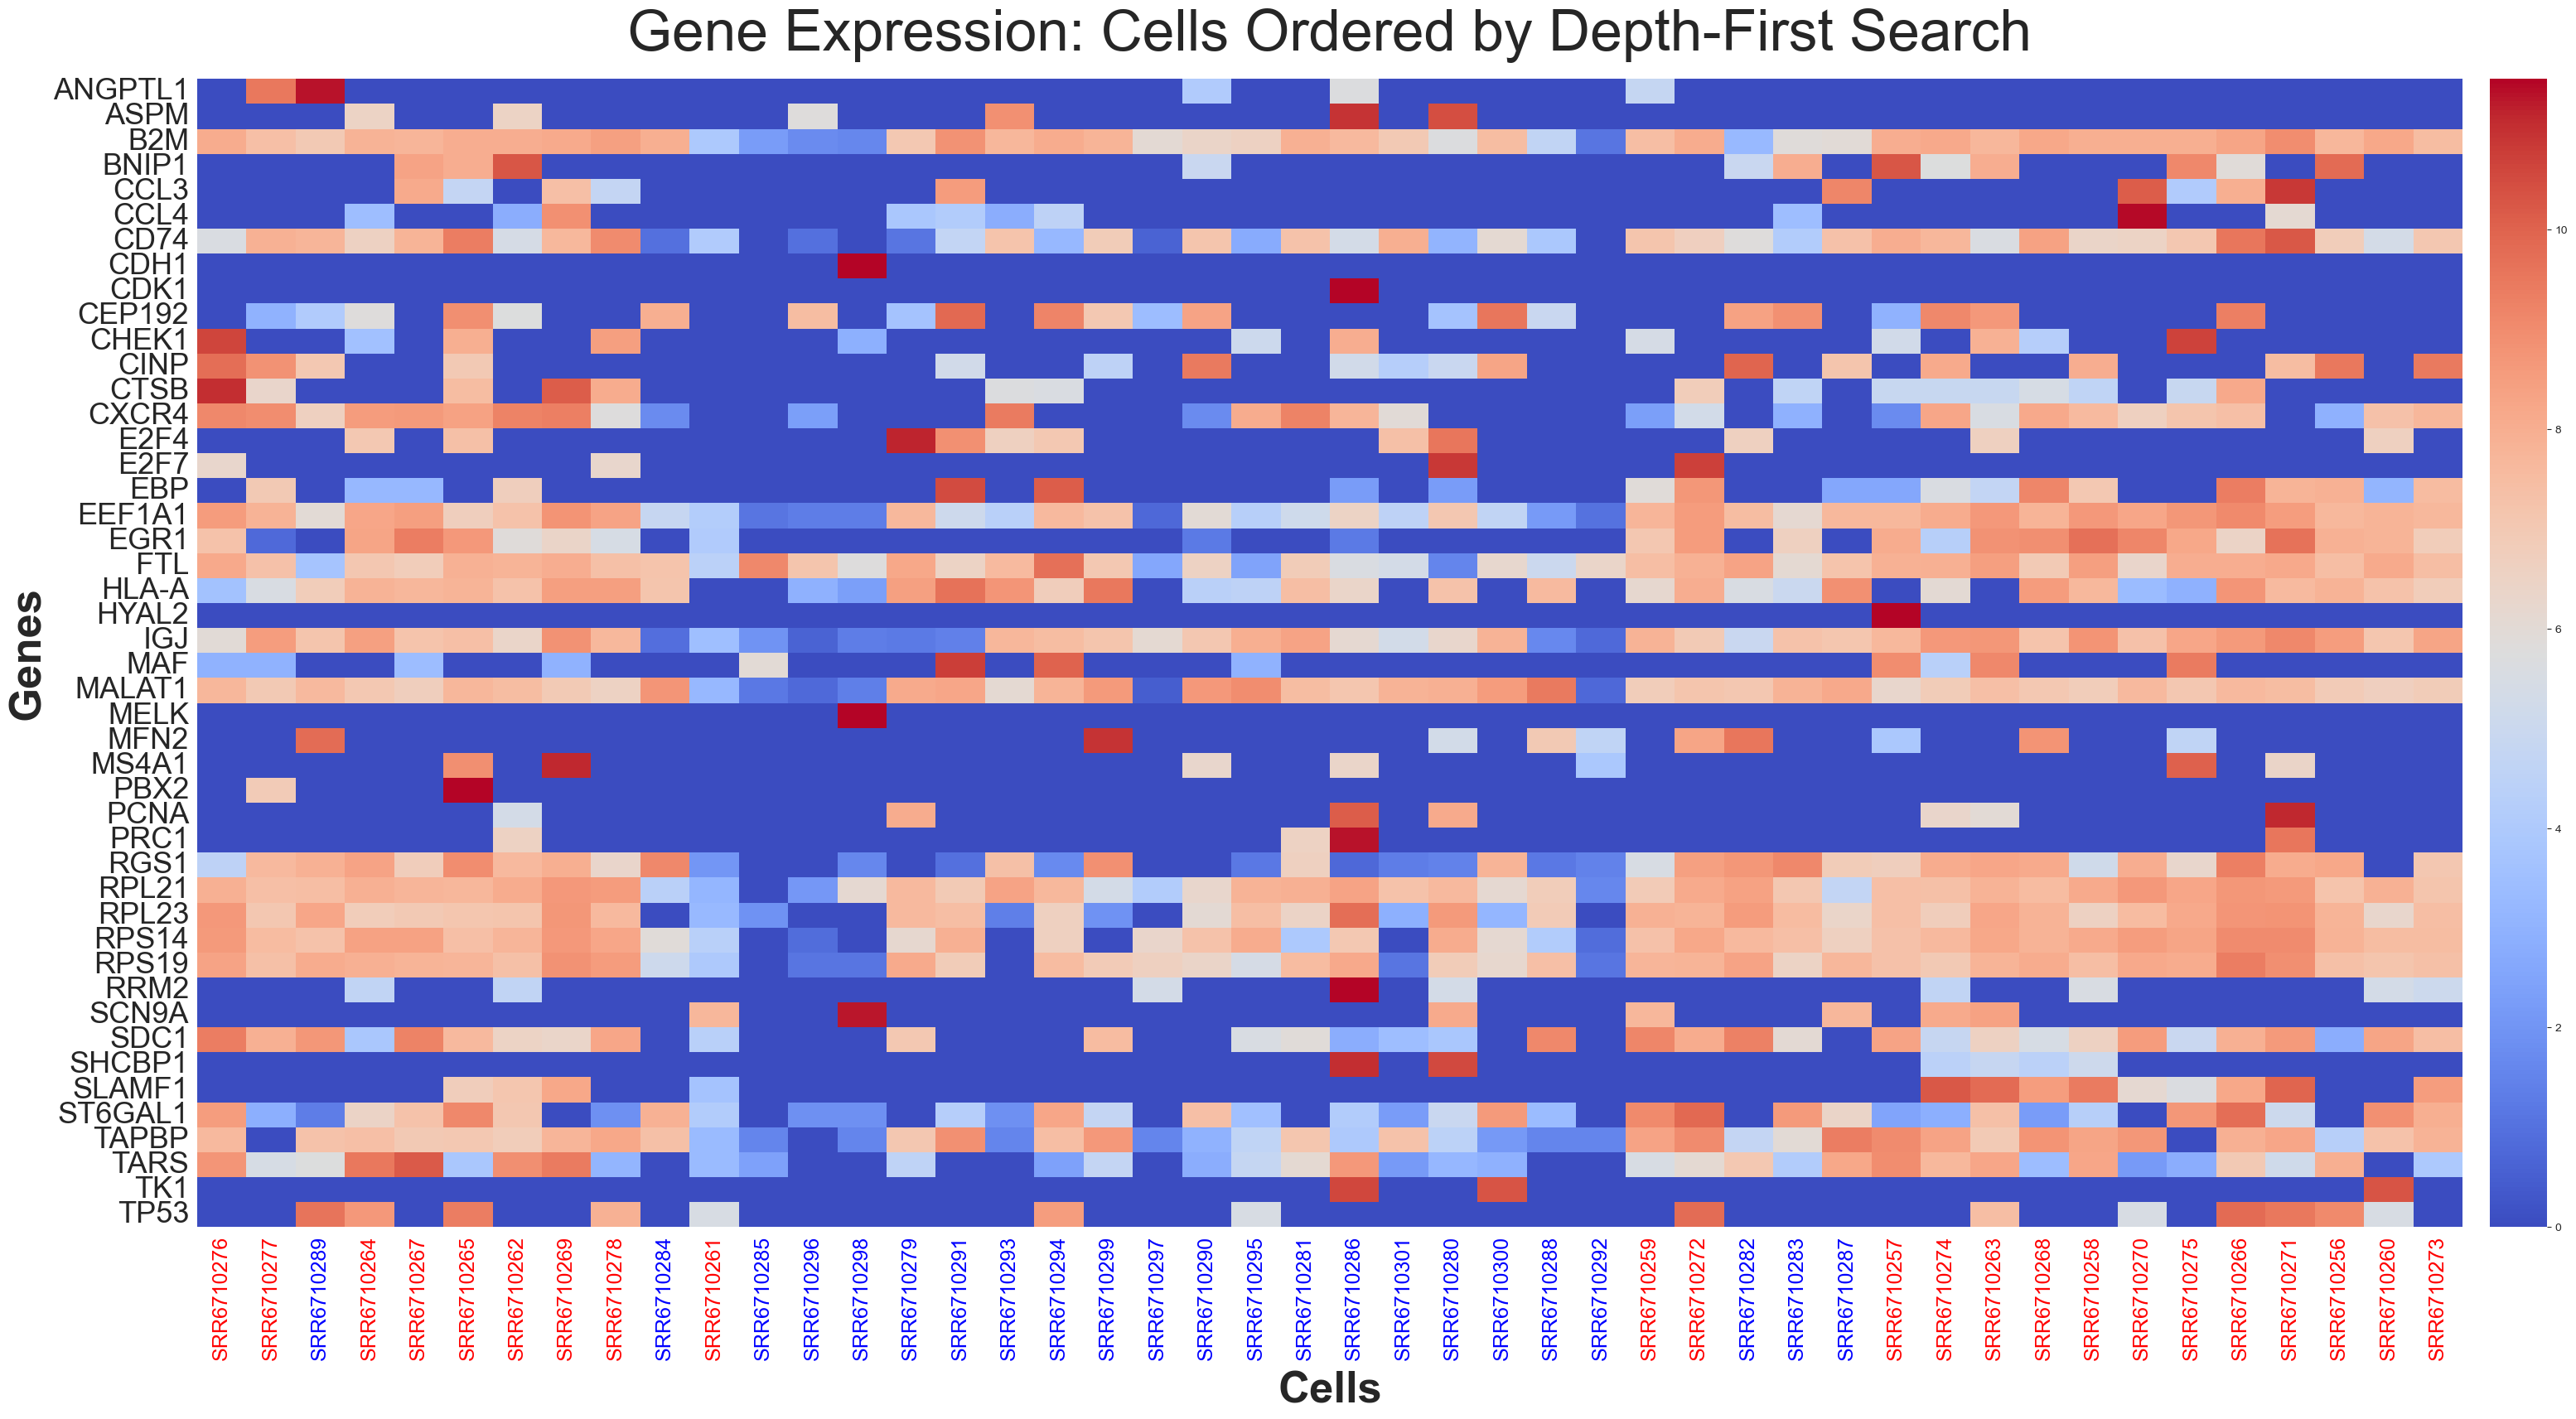

<Figure size 4000x2000 with 0 Axes>

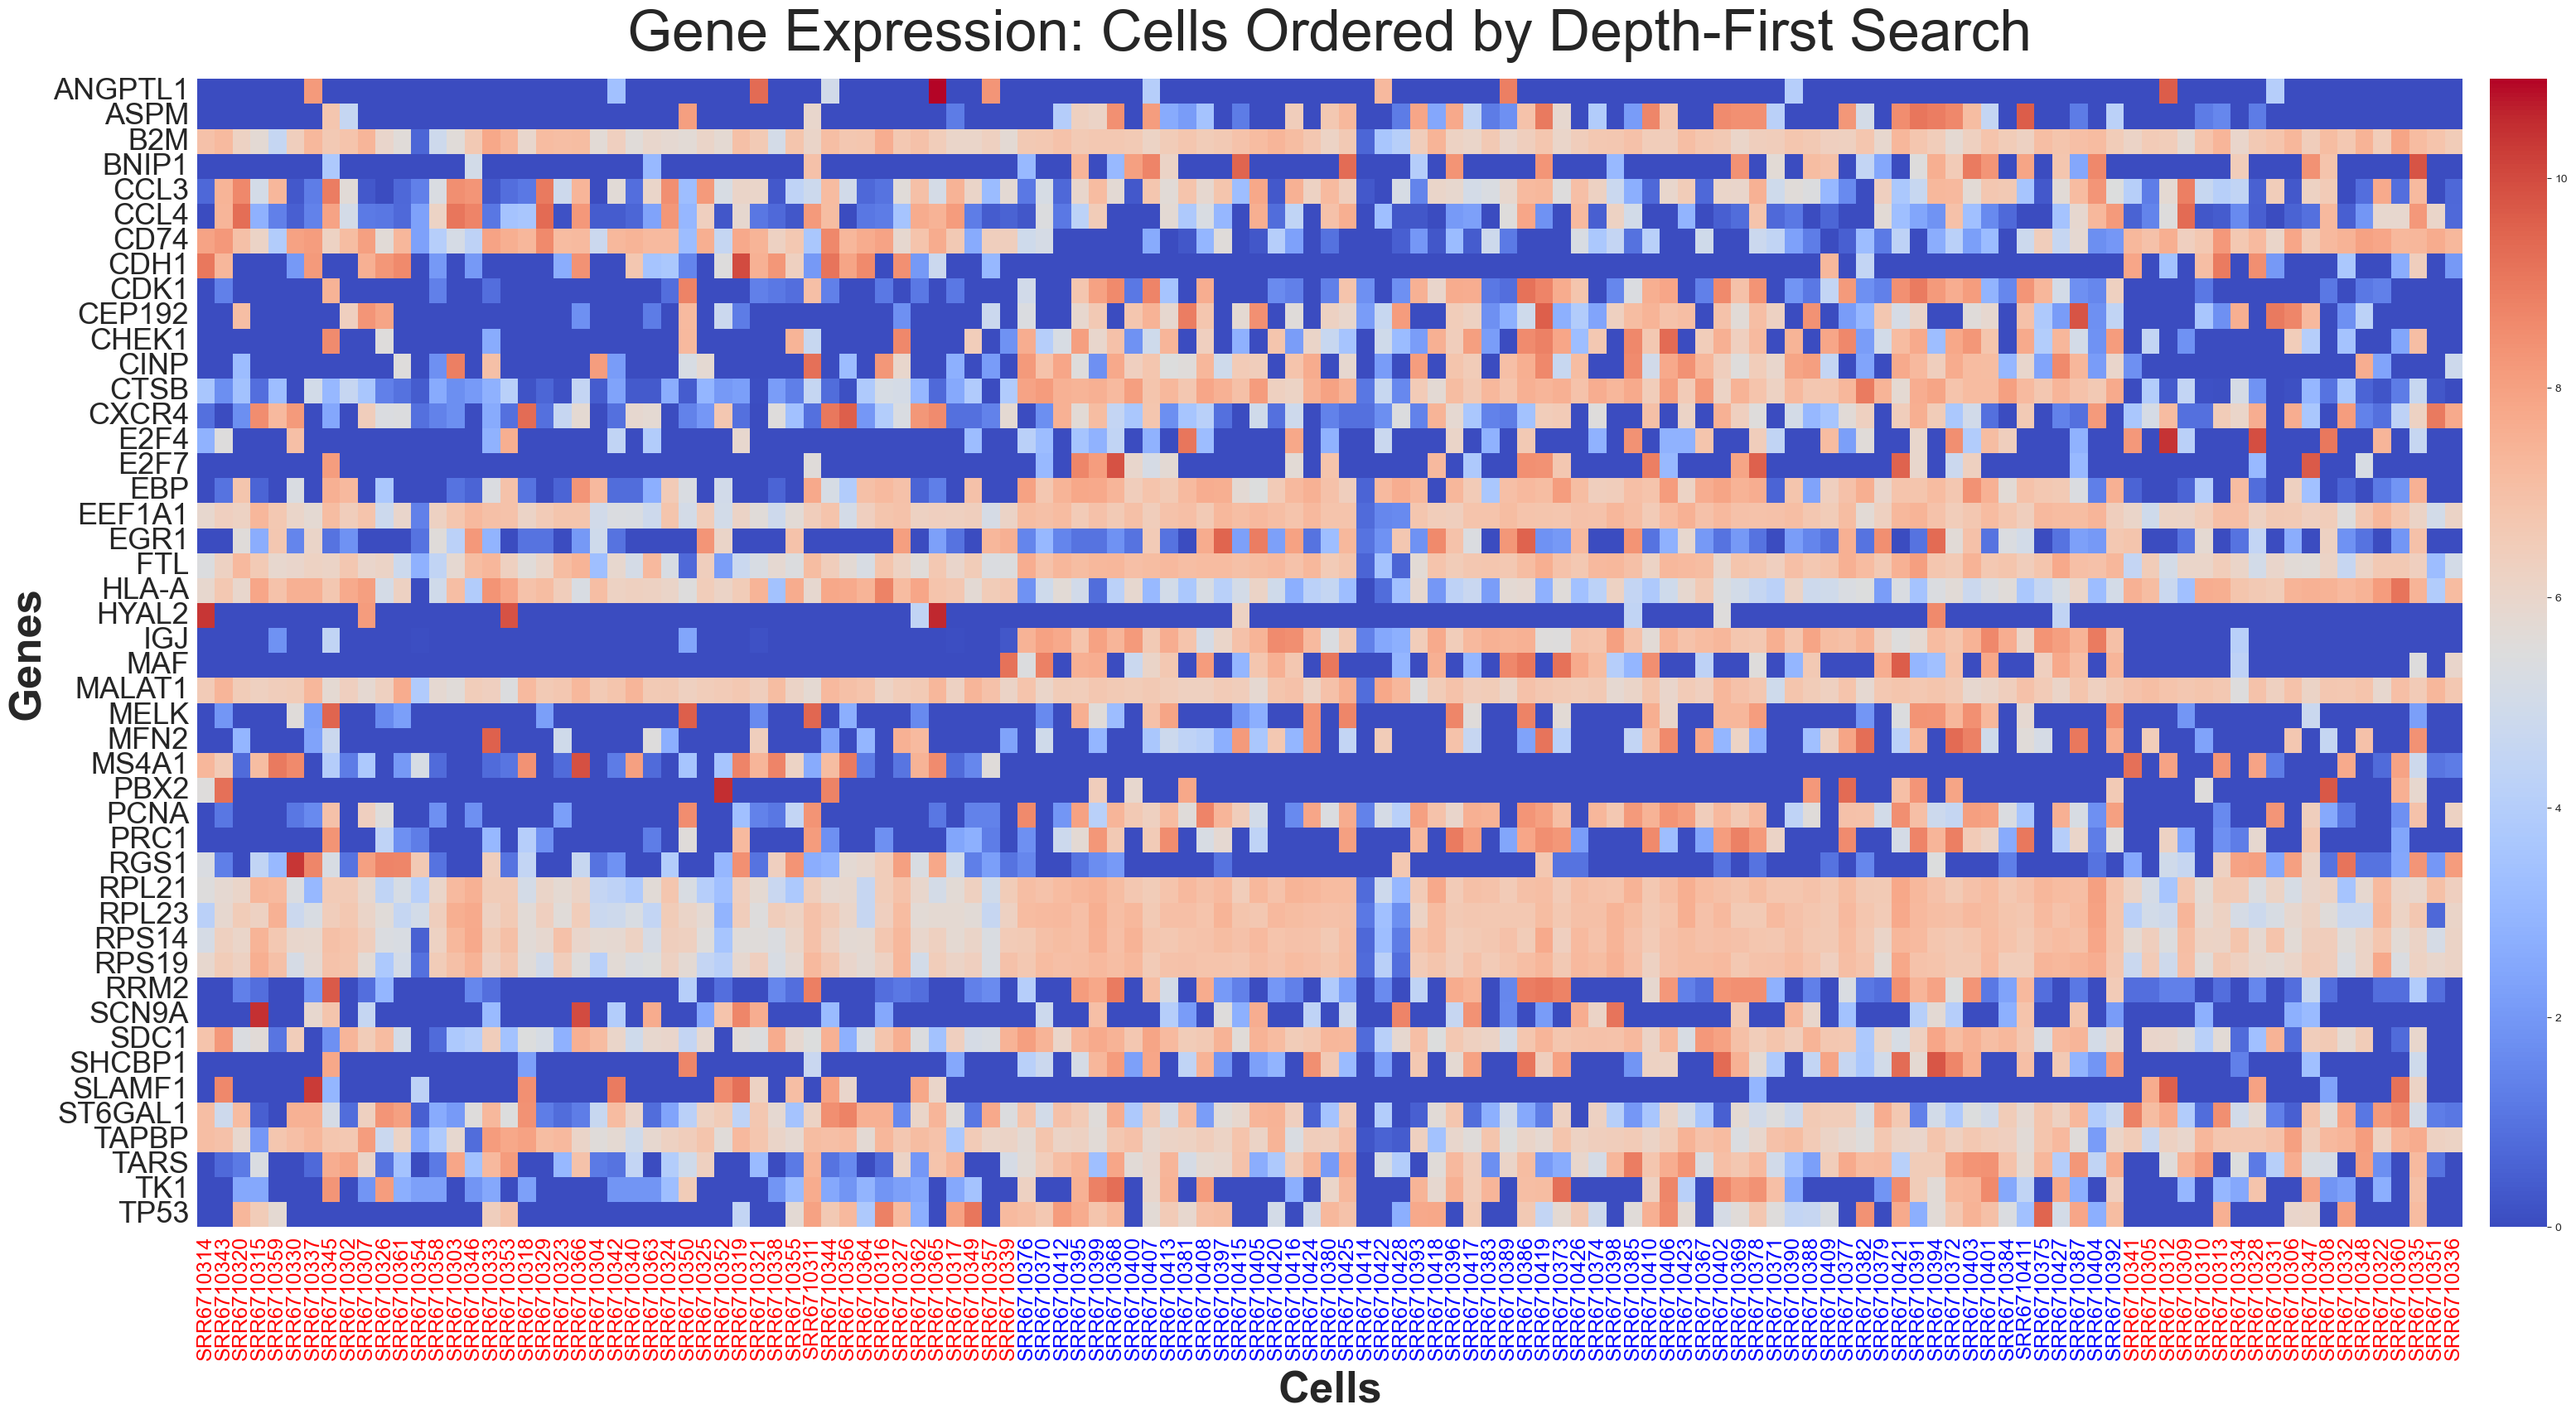

In [6]:
for study_num in study_nums:
    sorted_indices = leaf_orders[study_num]

    plt.figure(figsize=(40, 20))

    genes = ["IGJ", "CTSB", "EGR1", "FTL", "MALAT1", "RPL21", "SDC1", "SLAMF1", "CDH1", "ETV7", "CXCR4", "E2F4", "ANGPTL1", "HYAL2", "PBX2", "SCN9A", "BNIP1", "MFN2", "CEP192", "TARS", "E2F7", "MELK", "CHEK1", "EBP", "CINP", "PCNA", "ASPM", "CDK1", "MAF", "TP53", "MS4A1", "RGS1", "ST6GAL1", "HLA-A", "TAPBP", "CD74", "B2M", "CCL3", "CCL4", "RPS14","RPS19", "RPL23", "EEF1A1", "TK1", "RRM2","SHCBP1", "PRC1"]

    exp = expression_counts_scaled[study_num]
    chosen_genes = exp[exp.index.isin(genes)]
    sorted_df = chosen_genes.iloc[:, sorted_indices]

    col_colors = ["red" if val in primary_cells[study_num] else "blue" for val in sorted_indices]

    plt.figure(figsize=(42, 18))
    ax = sns.heatmap(sorted_df, cmap="coolwarm", cbar_kws={"pad": 0.01})

    for n, tick_label in enumerate(ax.get_xticklabels()):
        tick_label.set_color(col_colors[n])
        tick_label.set_fontsize(18)

    for tick_label in ax.get_yticklabels():
        tick_label.set_fontsize(26)
        tick_label.set_rotation(0)

    plt.title("Gene Expression: Cells Ordered by Depth-First Search", fontsize=50, pad=25)
    plt.ylabel("Genes", fontsize=38, fontweight="bold")
    plt.xlabel("Cells", fontsize=38, fontweight="bold", labelpad=10)
    plt.savefig(rf"../data/results/figures/gene_expression_{study_num}.svg", format="svg")
    plt.show()

Estimating the model parameters

In [20]:
n_bootstrap = 1000

global_parameters = {}
mean_individual_overdispersions_h = {}
mean_individual_dropouts = {}

if not use_summary_statistics:
    for study_num in study_nums:
        path_bootstrap = rf"../data/results/{study_num}/sciterna_bootstrap"
        global_parameters[study_num] = []
        for i in range(n_bootstrap):
            for j in range(n_rounds-1, n_rounds):
                global_param = np.loadtxt(os.path.join(path_bootstrap, "sciterna_global_parameters", f"sciterna_global_parameters_{j}r{i}.txt")).tolist()
                global_parameters[study_num].append(global_param)
        global_parameters[study_num] = global_parameters[study_num] # Dropout, Overdispersion homozygous, Error Rate, Overdispersion heterozygous

        selected = np.loadtxt(os.path.join(path_bootstrap, "selected.txt"), delimiter=",", dtype=int)
        ref = pd.read_csv(os.path.join(f"../data/input_data/{study_num}", "ref.csv"))

        all_individual_overdispersions_h = np.full((n_bootstrap, ref.shape[1]), np.nan)
        all_individual_dropouts = np.full((n_bootstrap, ref.shape[1]), np.nan)

        for i in range(n_bootstrap):
            for j in range(n_rounds-1, n_rounds):
                selected_mutations = np.loadtxt(os.path.join(path_bootstrap, "sciterna_selected_loci", f"sciterna_selected_loci_{j}r{i}.txt"), dtype=int)
                individual_dropouts = np.loadtxt(os.path.join(path_bootstrap, "sciterna_individual_dropout_probs", f"sciterna_individual_dropout_probs_{j}r{i}.txt"))
                individual_overdispersions_h = np.loadtxt(os.path.join(path_bootstrap, "sciterna_individual_overdispersions_h", f"sciterna_individual_overdispersions_h_{j}r{i}.txt"))

                unique_mutations = np.unique(selected_mutations)
                for mut in unique_mutations:
                    indices = np.where(selected_mutations == mut)[0]
                    mean_dropout = np.mean(individual_dropouts[indices])
                    mean_overdispersion = np.mean(individual_overdispersions_h[indices])

                    all_individual_dropouts[i, mut] = mean_dropout
                    all_individual_overdispersions_h[i, mut] = mean_overdispersion

        global_parameters_sample = np.array(global_parameters[study_num])

        sufficient_data_columns_od = ~np.any(
            all_individual_overdispersions_h == global_parameters_sample[:, 3][:, np.newaxis], axis=0
        )

        sufficient_data_columns_dropout = ~np.any(
            all_individual_dropouts == global_parameters_sample[:, 0][:, np.newaxis], axis=0
        )
        mean_individual_overdispersions_h[study_num] = np.nanmean(all_individual_overdispersions_h[:, sufficient_data_columns_od], axis=0).tolist()
        mean_individual_dropouts[study_num] = np.nanmean(all_individual_dropouts[:, sufficient_data_columns_dropout], axis=0).tolist()

else:
    with open("../data_summary/real_data/global_parameters.json", "r") as f:
        global_parameters = json.load(f)
    with open("../data_summary/real_data/mean_individual_overdispersions_h.json", "r") as f:
        mean_individual_overdispersions_h = json.load(f)
    with open("../data_summary/real_data/mean_individual_dropouts.json", "r") as f:
        mean_individual_dropouts = json.load(f)

FileNotFoundError: ../data/results/mm16/sciterna_bootstrap\sciterna_global_parameters\sciterna_global_parameters_1r0.txt not found.

In [21]:
study_nums = ["mm16", "mm34"]
for study_num in study_nums:
    # get the individual parameters, that were optimized for each SNV, instead of using the global parameter value
    mean_dropouts = mean_individual_dropouts[study_num]
    mean_overdispersions = mean_individual_overdispersions_h[study_num]
    path_bootstrap = rf"../data/results/{study_num}/sciterna_bootstrap"

    plt.hist(mean_overdispersions, bins=20, color="lightblue")
    plt.grid(False)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.title(f"Overdispersion {study_num}")
    plt.tight_layout()
    # plt.savefig(os.path.join(path_bootstrap, "overdispersion_histogram.svg"), format="svg")
    plt.show()

    plt.hist(mean_dropouts, bins=20, color="lightblue")
    plt.grid(False)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.title(f"Dropout {study_num}")
    plt.tight_layout()
    # plt.savefig(os.path.join(path_bootstrap, "dropout_histogram.svg"), format="svg")
    plt.show()

KeyError: 'mm16'

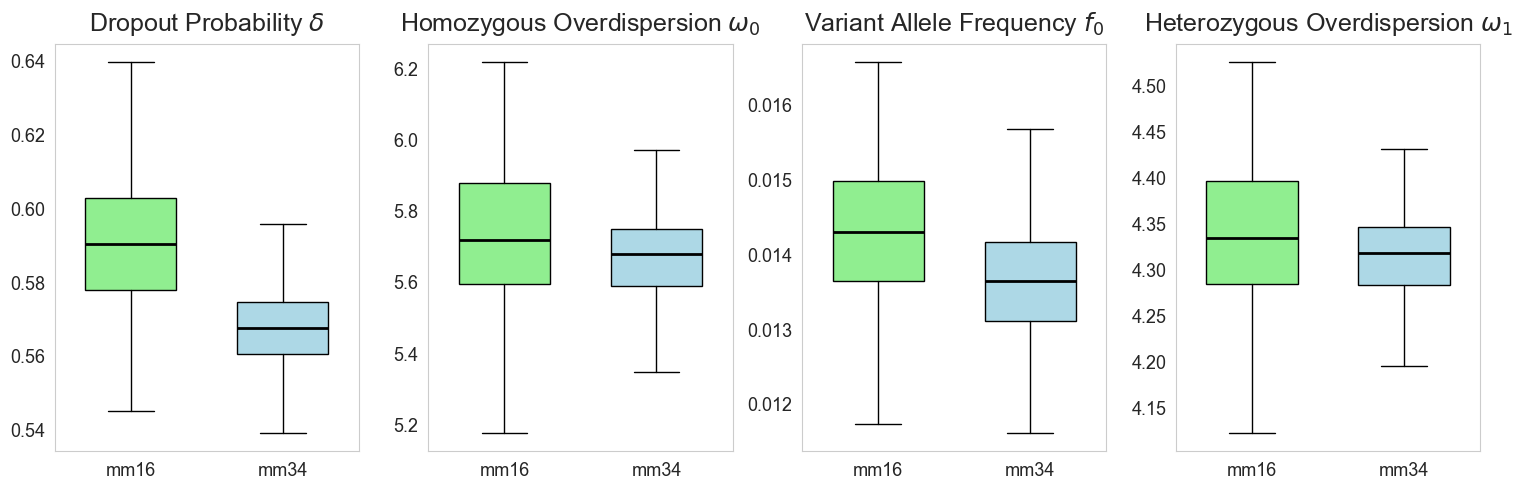

In [9]:
param_names = [r"Dropout Probability $\delta$", r"Homozygous Overdispersion $\omega_\mathrm{0}$", r"Variant Allele Frequency $f_\mathrm{0}$", r"Heterozygous Overdispersion $\omega_\mathrm{1}$"]

for study_num in study_nums:
    global_parameters[study_num] = np.array(global_parameters[study_num])

fig, axes = plt.subplots(1, 4, figsize=(15, 5))
box_colors = ["lightgreen", "lightblue", "lightcoral", "khaki"]

for idx, param_name in enumerate(param_names):
    data = [global_parameters[s][:, idx] for s in study_nums]
    bplot = axes[idx].boxplot(data, patch_artist=True, labels=study_nums, showfliers=False, widths=0.6)

    for patch, color in zip(bplot["boxes"], box_colors):
        patch.set_facecolor(color)
        patch.set_edgecolor("black")

    for median in bplot["medians"]:
        median.set_color("black")
        median.set_linewidth(2)

    axes[idx].set_title(param_name, fontsize=18, pad=10)
    axes[idx].set_ylabel(f"", fontsize=14)
    axes[idx].tick_params(axis="x", labelsize=13)
    axes[idx].tick_params(axis="y", labelsize=13)
    axes[idx].grid(False)

plt.tight_layout()
# plt.savefig(r"..\data\results\figures\global_parameters.pdf", format="pdf")
plt.show()

In [10]:
# mod = "BT_S2"
# alt = np.array(pd.read_csv(rf"C:\Users\Norio\Documents\GitHub\SCITE-RNA-v2\data\input_data\{mod}\alt.csv", dtype=str))[:,1:].astype(int)
# ref = np.array(pd.read_csv(rf"C:\Users\Norio\Documents\GitHub\SCITE-RNA-v2\data\input_data\{mod}\ref.csv", dtype=str))[:,1:].astype(int)
#
# np.savetxt(rf"C:\Users\Norio\Documents\GitHub\SCITE-RNA-v2\data\results\{mod}\alt.txt", alt, fmt="%d")
# np.savetxt(rf"C:\Users\Norio\Documents\GitHub\SCITE-RNA-v2\data\results\{mod}\ref.txt", ref, fmt="%d")

In [146]:
# GLIOBLASTOMA DATASET
study_num = "BT_S2"
path= rf"../data/results/{study_num}"

path_cell_types = rf"..\data\input_data\{study_num}\SraRunTable_BT_S2.csv"
cell_types = pd.read_csv(path_cell_types) #["cell_type"] ["Run"]
cell_names = pd.read_csv(rf"..\data\input_data\{study_num}/ref.csv")["Cell"]

run_names = cell_types["Run"].astype(str).tolist()

run_to_type = {}
df_map = cell_types.set_index(cell_types["Run"].astype(str))["cell_type"].to_dict()
for i, run in enumerate(run_names):
    run_to_type[str(run)] = df_map.get(str(run), "unknown")

unique_types = sorted(set(run_to_type.values()))
colors = ["orange", "red", "blue", "green", "purple", "brown", "pink", "gray", "olive", "cyan"]
type_to_color = {t: colors[i] for i, t in enumerate(unique_types)}

In [93]:
np.unique(cell_types["tissue"], return_counts=True)

(array(['Periphery', 'Tumor'], dtype=object), array([446, 723], dtype=int64))

In [94]:
def plot_trees(inpath, test, round="", model="", plot_mutations=False, cell_names=None):

    path_parent = os.path.join(inpath, model, f"{model}_parent_vec", f"{model}_parent_vec{round}{test}.txt")
    path_mut_loc = os.path.join(inpath, model, f"{model}_mutation_location", f"{model}_mutation_location{round}{test}.txt")
    path_selected = os.path.join(inpath, model, f"{model}_selected_loci", f"{model}_selected_loci{round}{test}.txt")

    parent_vec = np.loadtxt(path_parent, dtype=int)
    if os.path.exists(path_mut_loc) == False:
        mut_locs = []
        selected_mutations = []
    else:
        mut_locs = np.loadtxt(path_mut_loc, dtype=int)
        selected_mutations = np.loadtxt(path_selected, dtype=int)

    n_cells = int(((len(parent_vec)+1)/2))

    ct = CellTree(n_cells=n_cells, n_mut=len(selected_mutations))
    ct.use_parent_vec(parent_vec)

    if plot_mutations:
        ct.mut_loc = mut_locs
        graph = ct.to_graphviz()

        for n, run_name in enumerate(cell_names):
            ctype = run_to_type.get(run_name, "unknown")
            fillcolor = type_to_color.get(ctype, "#c0c0c0")
            graph.node(str(n), shape="circle", style="filled", fillcolor=fillcolor, color="black")
            graph.node(str(n), label=run_name)

        graph.render(os.path.join(inpath, model, f"{model}_ct_trees", f"ct_tree{round}{test}"), format="png", cleanup=True)

    ct.mut_loc = []
    graph_branches = ct.to_graphviz()
    for n, run_name in enumerate(cell_names):
        ctype = run_to_type.get(run_name, "unknown")
        fillcolor = type_to_color.get(ctype, "#c0c0c0")
        graph_branches.node(str(n), shape="circle", style="filled", fillcolor=fillcolor, color="black")
        graph_branches.node(str(n), label=run_name)


    # with graph_branches.subgraph(name="cluster_legend") as c:
    #     c.attr(label="Legend", fontsize="10")
    #     c.attr(rank="same")
    #     for i, t in enumerate(unique_types):
    #         node_name = f"legend_{i}"
    #         c.node(node_name, label=t, shape="box", style="filled", fillcolor=type_to_color[t], color="black")

    graph_branches.render(os.path.join(inpath, model, f"{model}_ct_trees", f"ct_tree{round}{test}_branches_loc"), format="png", cleanup=True)
    return graph_branches, parent_vec, ct

graph, parent_vector, ct_sciterna = plot_trees(path, test="0", round="_1r", model="sciterna", cell_names=cell_names, plot_mutations=False)
# g, p = plot_trees(path, test="", round="", model="dendro", cell_names=cell_names, plot_mutations=False)

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.395412 to fit


ValueError: too many values to unpack (expected 2)

In [101]:
tumor_cells = [run_to_type.get(cell_names[c]) for c in ct_sciterna.dfs(1704) if ct_sciterna.isleaf(c)] #1725
total_tumor_branch = np.sum([1 if t=="Neoplastic"  else 0 for t in tumor_cells])
total_healthy_branch = np.sum([1 if t!="Neoplastic" else 0 for t in tumor_cells])
purity_tumor = total_tumor_branch/len(tumor_cells)

print("Purity tumor:", np.sum([1 if t=="Neoplastic"  else 0 for t in tumor_cells])/len(tumor_cells), "Tumor cells:", total_tumor_branch, "Healthy cells:", total_healthy_branch)

Purity tumor: 0.9282786885245902 Tumor cells: 453 Healthy cells: 35


In [104]:
tumor_indices = [c for c in ct_sciterna.dfs(1704) if ct_sciterna.isleaf(c)]
non_tumor_indices = [c for c in range(len(cell_names)) if c not in tumor_indices]
non_tumor_cells = [run_to_type.get(cell_names[c]) for c in non_tumor_indices]

purity_non_tumor = np.sum([t == "Neoplastic" for t in non_tumor_cells]) / len(non_tumor_cells)
total_tumor_rest = np.sum([t == "Neoplastic" for t in non_tumor_cells])
total_healthy_rest = np.sum([t != "Neoplastic" for t in non_tumor_cells])
print("Purity non-tumor branch:", purity_non_tumor, "Tumor cells:", total_tumor_rest, "Healthy cells:", total_healthy_rest)
print("Fraction of tumor cells in branch:", total_tumor_branch/(total_tumor_branch+total_tumor_rest))
print("Fraction of healthy cells in rest:", total_healthy_rest/(total_healthy_rest+total_healthy_branch))
print("Purity of healthy cells in rest:", total_healthy_rest/(total_healthy_rest+total_tumor_rest))

Purity non-tumor branch: 0.1145374449339207 Tumor cells: 78 Healthy cells: 603
Fraction of tumor cells in branch: 0.8531073446327684
Fraction of healthy cells in rest: 0.945141065830721
Purity of healthy cells in rest: 0.8854625550660793


In [15]:
# def plot_trees(inpath, model="", cell_names=None):
#     path_parent = os.path.join(inpath, model, f"{model}_parent_vec_clustering", f"{model}_parent_vec_clustering.txt")
#     parent_vec = np.loadtxt(path_parent, dtype=int)
#
#     n_cells = int(((len(parent_vec)+1)/2))
#
#     ct = CellTree(n_cells=n_cells, n_mut=3)
#     ct.use_parent_vec(parent_vec)
#
#     ct.mut_loc = []
#     graph_branches = ct.to_graphviz()
#     for n, run_name in enumerate(cell_names):
#         ctype = run_to_type.get(run_name, "unknown")
#         fillcolor = type_to_color.get(ctype, "#c0c0c0")
#         graph_branches.node(str(n), shape="circle", style="filled", fillcolor=fillcolor, color="black")
#         graph_branches.node(str(n), label=run_name)
#
#
#     with graph_branches.subgraph(name="cluster_legend") as c:
#         c.attr(label="Legend", fontsize="10")
#         c.attr(rank="same")
#         for i, t in enumerate(unique_types):
#             node_name = f"legend_{i}"
#             c.node(node_name, label=t, shape="box", style="filled", fillcolor=type_to_color[t], color="black")
#
#     graph_branches.render(os.path.join(inpath, model, f"{model}_ct_trees", f"ct_tree_clustering"), format="png", cleanup=True)
#     return graph_branches, parent_vec
#
# g, p = plot_trees(path, model="sciterna", cell_names=cell_names)

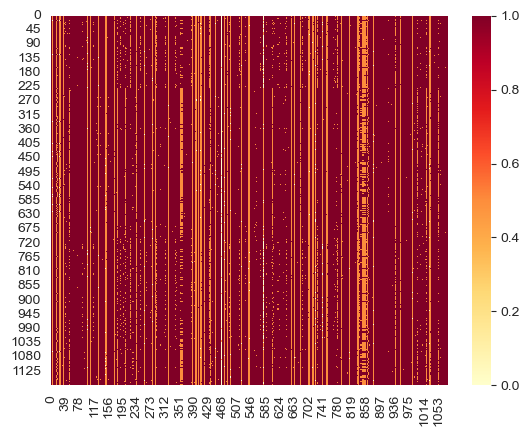

C:\Users\Norio\AppData\Local\Temp\ipykernel_24132\2900310640.py:14: RuntimeWarning: invalid value encountered in divide
  vaf = np.where((ref + alt) == 0, np.nan, alt / (ref + alt))
C:\Users\Norio\AppData\Local\Temp\ipykernel_24132\2900310640.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("YlOrRd").copy() if hasattr(plt.cm.get_cmap("YlOrRd"), "copy") else plt.cm.get_cmap("YlGnBu")


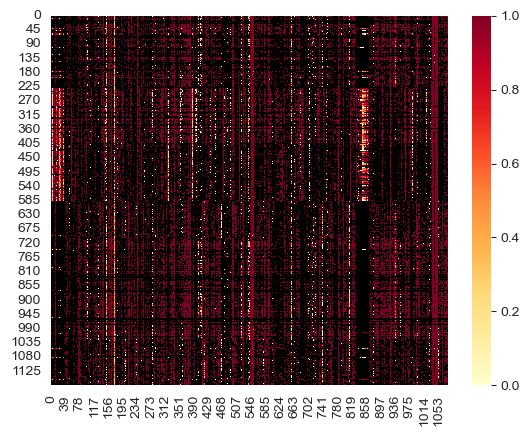

In [138]:
def plot_genotypes(model="sciterna"):
    genotype_predicted = np.loadtxt(os.path.join(path, model, f"{model}_genotype", f"{model}_genotype_1r0.txt"), dtype=str)
    mapping_dict = {'A': 1.0, 'H': 0.5, 'R': 0}
    vectorized_map = np.vectorize(lambda x: float(mapping_dict[x]))
    genotype_predicted = vectorized_map(genotype_predicted)

    alt = np.array(pd.read_csv(r"C:\Users\Norio\Documents\GitHub\SCITE-RNA-v2\data\input_data\BT_S2\alt.csv", dtype=str))[:,1:].astype(int)
    ref = np.array(pd.read_csv(r"C:\Users\Norio\Documents\GitHub\SCITE-RNA-v2\data\input_data\BT_S2\ref.csv", dtype=str))[:,1:].astype(int)


    sns.heatmap(genotype_predicted, cmap="YlOrRd")
    plt.show()

    vaf = np.where((ref + alt) == 0, np.nan, alt / (ref + alt))

    cmap = plt.cm.get_cmap("YlOrRd").copy() if hasattr(plt.cm.get_cmap("YlOrRd"), "copy") else plt.cm.get_cmap("YlGnBu")
    cmap.set_bad("black")

    sns.heatmap(vaf, cmap=cmap, vmin=0.0, vmax=1.0)
    plt.show()
plot_genotypes()

C:\Users\Norio\AppData\Local\Temp\ipykernel_24132\3697779521.py:25: RuntimeWarning: invalid value encountered in divide
  vaf = np.where((ref + alt) == 0, np.nan, alt / (ref + alt))
C:\Users\Norio\AppData\Local\Temp\ipykernel_24132\3697779521.py:55: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("YlOrRd").copy()
C:\Users\Norio\AppData\Local\Temp\ipykernel_24132\3697779521.py:94: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


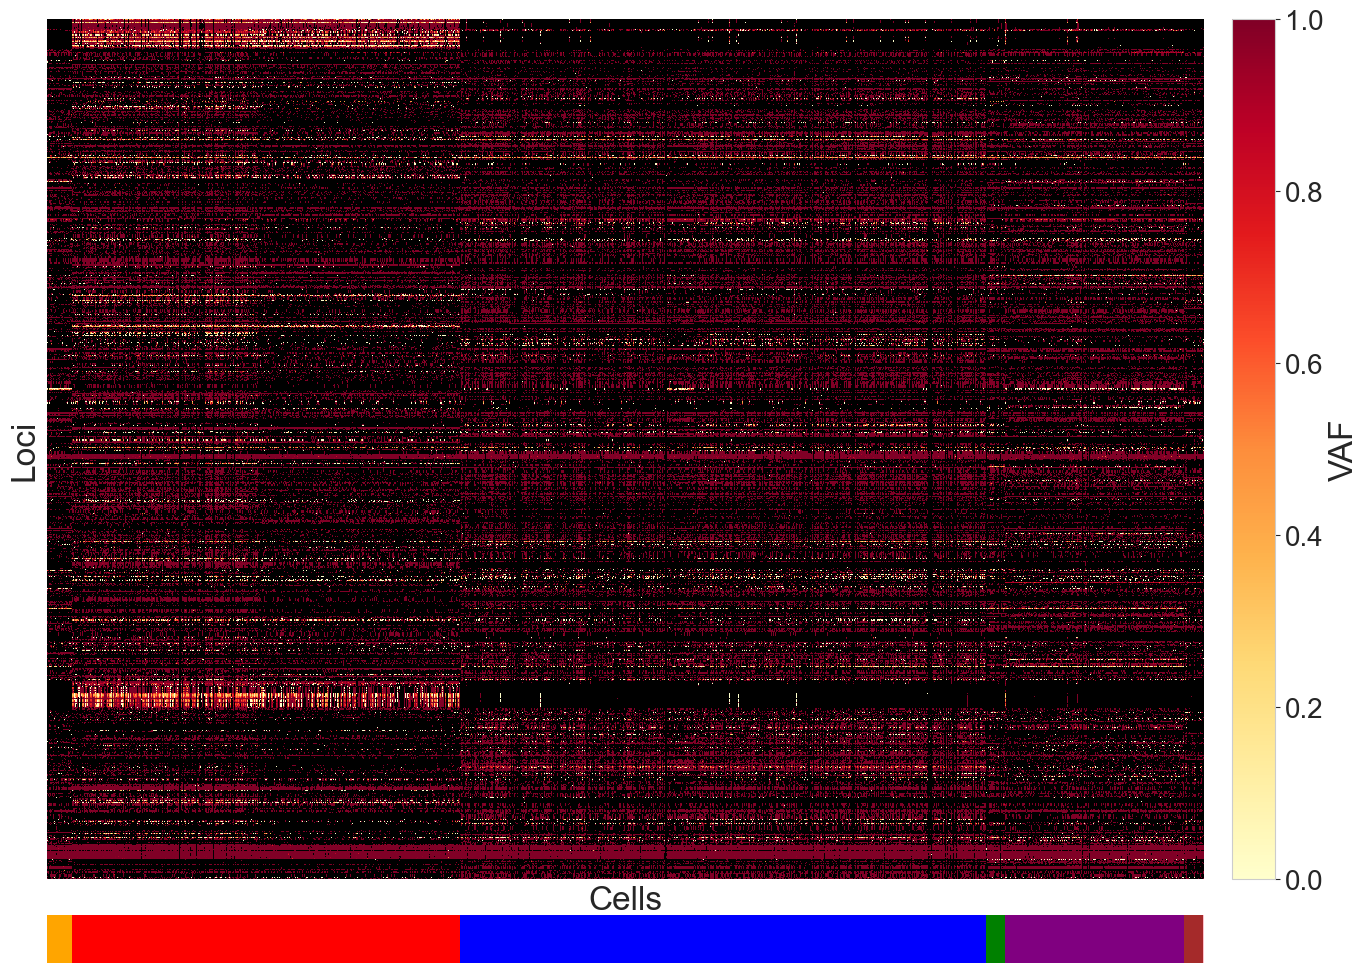

In [170]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch

def plot_genotypes(model="sciterna", run_to_type=None, type_to_color=None):

    # Load ref and alt data as DataFrames to preserve row (cell) and column (mutation) names
    alt_df = pd.read_csv(r"C:\Users\Norio\Documents\GitHub\SCITE-RNA-v2\data\input_data\BT_S2\alt.csv", index_col=0)
    ref_df = pd.read_csv(r"C:\Users\Norio\Documents\GitHub\SCITE-RNA-v2\data\input_data\BT_S2\ref.csv", index_col=0)

    genotype_predicted = np.loadtxt(os.path.join(path, model, f"{model}_genotype", f"{model}_genotype_1r0.txt"), dtype=str)
    mapping_dict = {'A': 1.0, 'H': 0.5, 'R': 0}
    vectorized_map = np.vectorize(lambda x: float(mapping_dict[x]))
    genotype_predicted = vectorized_map(genotype_predicted)

    # Extract row names (cell names)
    cell_names = alt_df.index

    # Calculate VAF
    alt = alt_df.values.astype(int)
    ref = ref_df.values.astype(int)
    vaf = np.where((ref + alt) == 0, np.nan, alt / (ref + alt))

    # Order rows (cells) by cell type
    if run_to_type is None or type_to_color is None:
        raise ValueError("run_to_type and type_to_color must be provided as dictionaries.")

    # Map cell names to types
    cell_types = [run_to_type.get(cell, "unknown") for cell in cell_names]

    # Get unique types and their order
    unique_types = sorted(
        set(cell_types),
        key=lambda x: list(type_to_color.keys()).index(x) if x in type_to_color else len(type_to_color)
    )

    # Order cell names by type
    ordered_cell_names = sorted(
        cell_names,
        key=lambda x: unique_types.index(run_to_type.get(x, "unknown"))
    )

    # Reorder VAF matrix to match ordered_cell_names
    row_indices = [list(cell_names).index(name) for name in ordered_cell_names]
    vaf_ordered = vaf[row_indices, :]      # still row-sorted
    vaf_ordered = vaf_ordered.T

    # Create a list of colors for each cell (row)
    row_colors = [type_to_color[run_to_type.get(cell, "unknown")] for cell in ordered_cell_names]

    # Plot VAF heatmap
    cmap = plt.cm.get_cmap("YlOrRd").copy()
    cmap.set_bad("black")

    fig = plt.figure(figsize=(18, 12))
    gs = fig.add_gridspec(2, 1, height_ratios=[0.94, 0.06], hspace=0.02)

    ax = fig.add_subplot(gs[0, 0])
    strip_ax = fig.add_subplot(gs[1, 0])

    hm = sns.heatmap(
        vaf_ordered,
        cmap=cmap,
        vmin=0.0,
        vmax=1.0,
        yticklabels=False,
        xticklabels=False,
        ax=ax,
        cbar=False       # we'll add our own colorbar on the right
)

    # ---- Add VAF colorbar on the right ----
    cbar = plt.colorbar(hm.collections[0], ax=ax, location="right", pad=0.02)
    cbar.set_label("VAF", fontsize=24)
    cbar.ax.tick_params(labelsize=20)

    # ---- Cell-type strip below ----
    for i, color in enumerate(row_colors):
        strip_ax.add_patch(plt.Rectangle((i, 0), 1, 1, color=color, linewidth=0))

    strip_ax.set_xlim(0, len(cell_names))
    strip_ax.set_ylim(0, 1)
    strip_ax.axis("off")

    # Align strip exactly with heatmap width
    ax_pos = ax.get_position()
    strip_ax.set_position([ax_pos.x0, ax_pos.y0 - 0.07, ax_pos.width, 0.04])

    ax.set_xlabel("Cells", fontsize=24)
    ax.set_ylabel("Loci", fontsize=24)
    plt.tight_layout()
    # plt.savefig(r"C:\Users\Norio\Documents\GitHub\SCITE-RNA-v2\data\results\BT_S2\sciterna\vaf.png", dpi=500)
    plt.show()

    return row_colors, ordered_cell_names

rcs, ocns = plot_genotypes(
    model="sciterna",
    run_to_type=run_to_type,
    type_to_color=type_to_color
)

In [20]:
def get_node_positions(dot):
    """Get x-coordinates of all nodes from Graphviz layout."""
    A = pgv.AGraph(string=dot.source if hasattr(dot, 'source') else dot)
    A.layout(prog="dot")
    positions = {}
    for node in A.nodes():
        name = node.get_name()
        if not name.isdigit():
            continue
        pos = node.attr.get('pos')
        if pos:
            x = float(pos.split(',')[0])
            positions[int(name)] = x
    return positions

def dfs_left_to_right(graph, root, n_cells, positions):

    leaf_order = []

    def dfs(node):
        children = graph.get(node, [])
        # Sort children by x-position
        children_sorted = sorted(children, key=lambda x: positions.get(x, float("inf")))
        if not children:
            if node < n_cells:  # leaf node condition
                leaf_order.append(node)
            return
        for child in children_sorted:
            dfs(child)

    dfs(root)
    return leaf_order

# Build adjacency list from parent vector
def build_adj_list(parent_vec):
    from collections import defaultdict
    adj = defaultdict(list)
    for child, parent in enumerate(parent_vec):
        if parent != -1:
            adj[parent].append(child)
    return adj

leaf_orders = {}

positions = get_node_positions(graph)
adj_list = build_adj_list(parent_vector)
root = np.where(np.array(parent_vector) == -1)[0][0]

leaf_orders[study_num] = dfs_left_to_right(adj_list, root, len(cell_names), positions)

<Figure size 4000x2000 with 0 Axes>

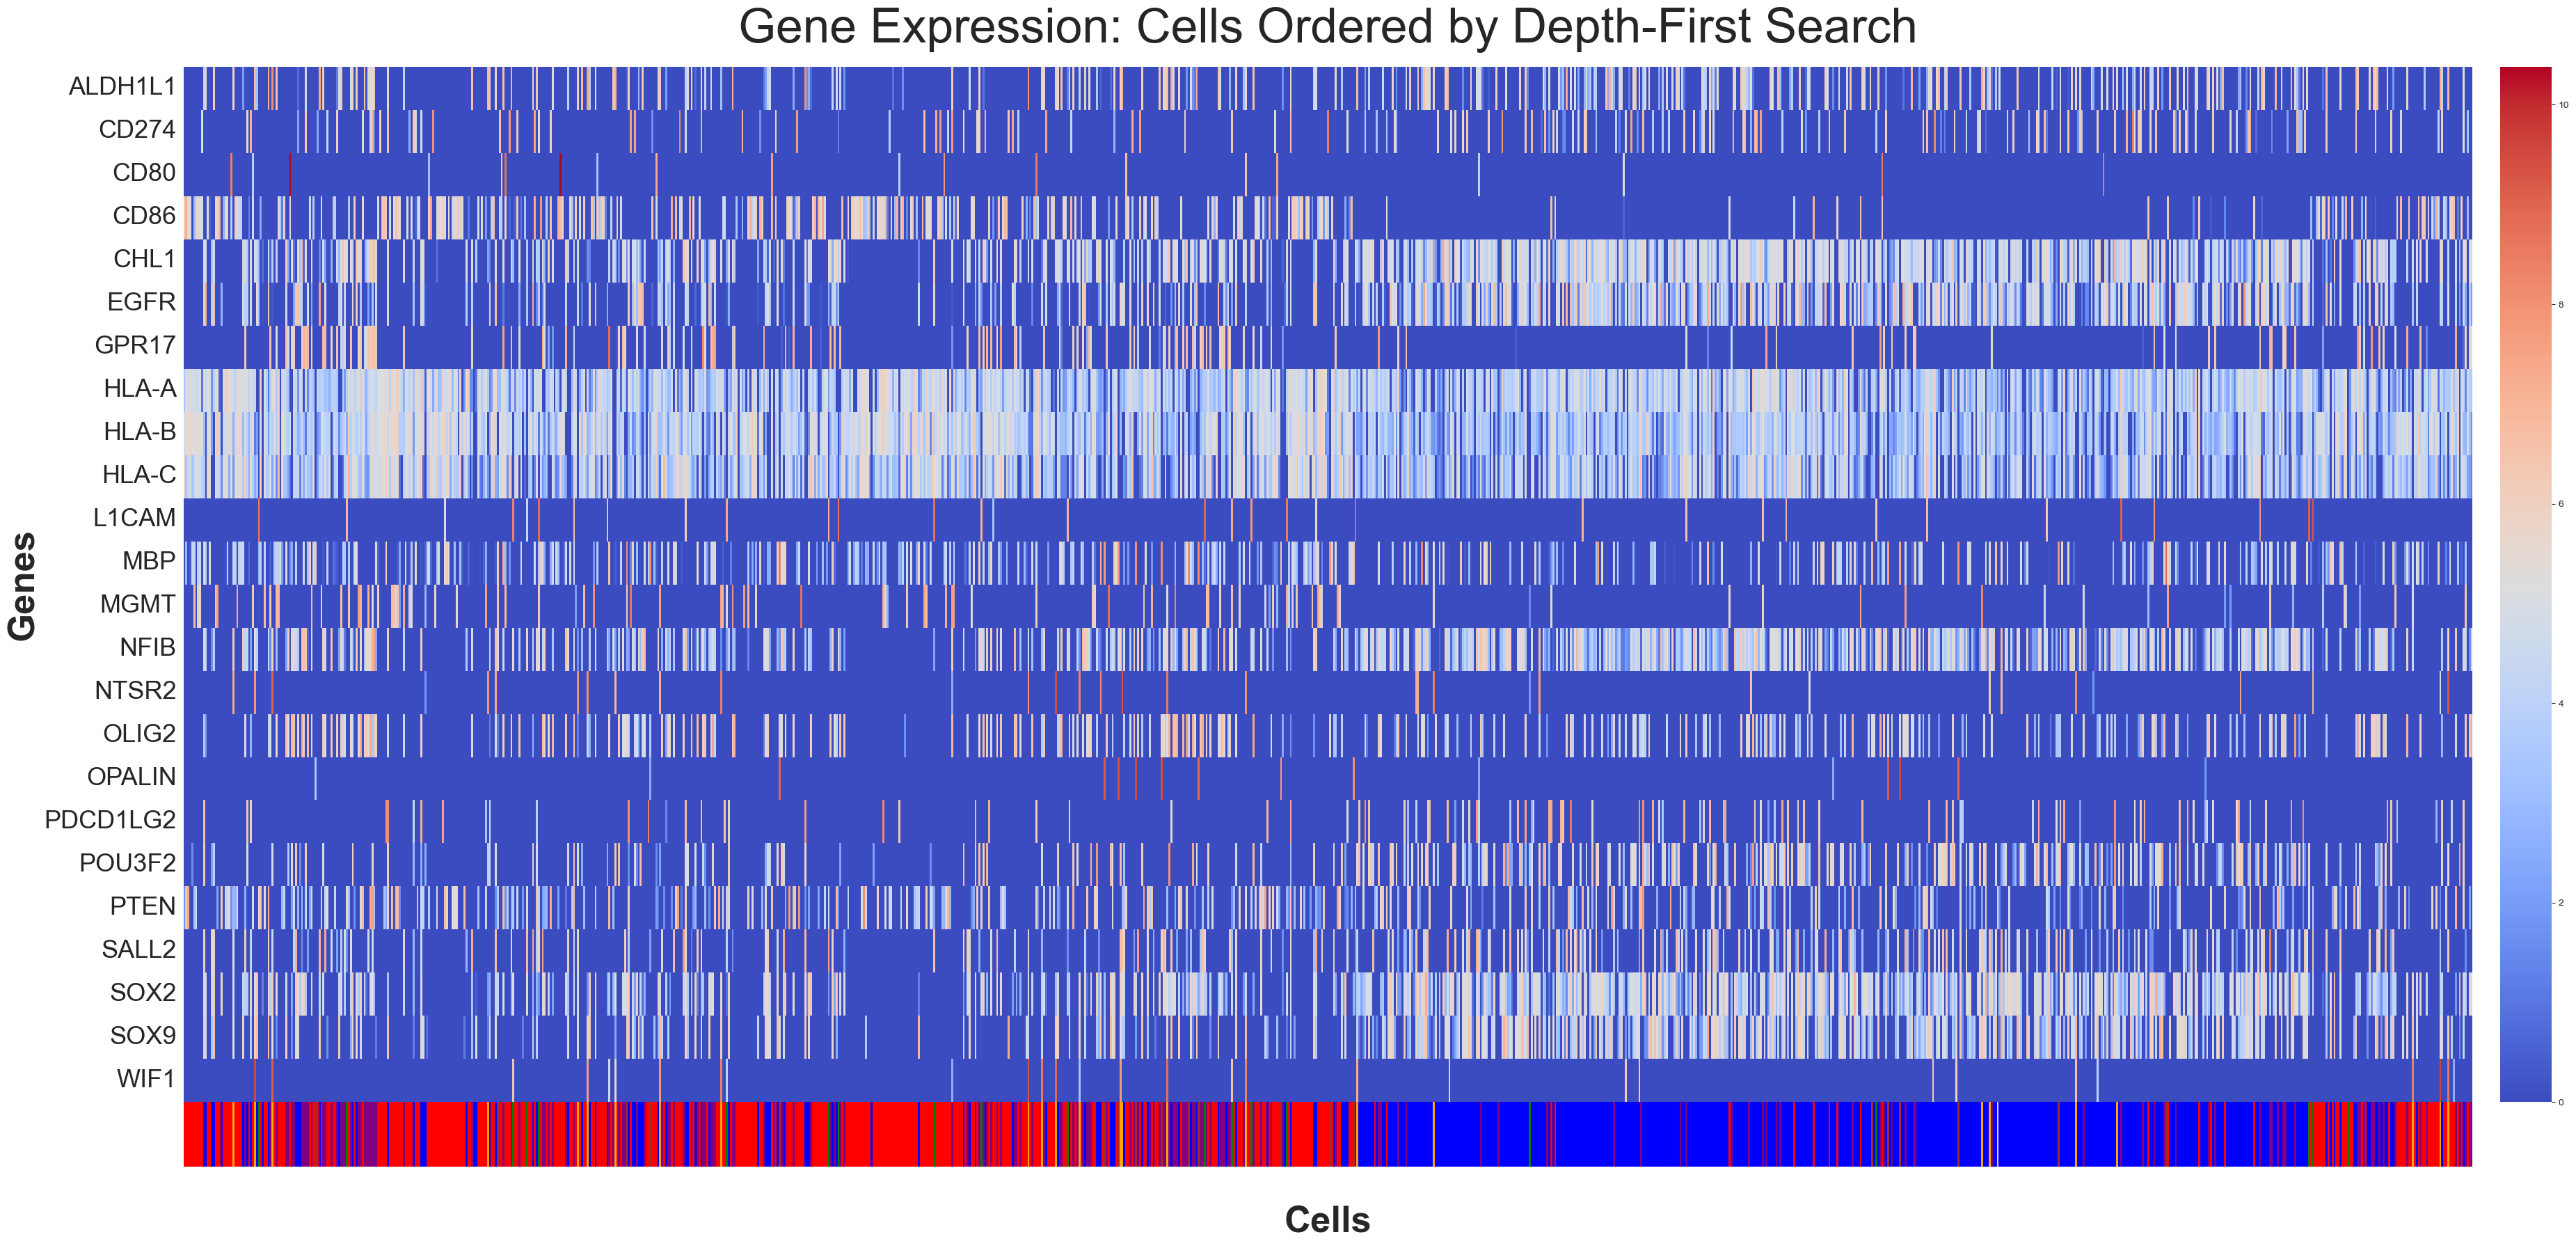

In [63]:
expression_counts = pd.read_csv(rf"../data/input_data/{study_num}/gene_expression_counts.csv", index_col=0)
normalized_counts = expression_counts.div(expression_counts.sum(axis=1), axis=0) * 1e5
expression_counts_scaled[study_num] = np.log1p(normalized_counts)

sorted_indices = leaf_orders[study_num]

plt.figure(figsize=(40, 20))

genes = [
    "EGFR", "CHL1", "SOX2", "SOX9", "POU3F2", "OLIG2", "SALL2", "NFIB",
    "MBP", "OPALIN", "GPR17", "L1CAM", "ALDH1L1", "WIF1", "NTSR2",
    "HLA-A", "HLA-B", "HLA-C", "CD274", "PDCD1LG2", "CD80", "CD86", "PTEN", "MGMT"
]

exp = expression_counts_scaled[study_num]
chosen_genes = exp[exp.index.isin(genes)]
sorted_df = chosen_genes.iloc[:, sorted_indices]

cells = sorted_df.columns.tolist()

col_colors = [type_to_color[run_to_type[cell]] for cell in cells]

plt.figure(figsize=(42, 18))
ax = sns.heatmap(sorted_df, cmap="coolwarm", cbar_kws={"pad": 0.01})

ax.set_xticklabels([])
ax.set_xlabel("Cells", fontsize=38, fontweight="bold", labelpad=100)

n_genes = sorted_df.shape[0]
from matplotlib.patches import Rectangle

n_cells = len(cells)
for i, color in enumerate(col_colors):
    ax.add_patch(
        Rectangle(
            (i, n_genes - 0.0),
            1, 1.5,         # width 1 cell, height
            color=color,
            transform=ax.transData,
            clip_on=False,
            linewidth=0
        )
    )

for tick_label in ax.get_yticklabels():
    tick_label.set_fontsize(26)
    tick_label.set_rotation(0)

plt.title("Gene Expression: Cells Ordered by Depth-First Search", fontsize=50, pad=25)
plt.ylabel("Genes", fontsize=38, fontweight="bold")

plt.tight_layout()
plt.savefig(rf"../data/results/figures/gene_expression_{study_num}.png", format="png", dpi=500)
plt.show()

In [135]:
def to_newick(ct, node):
    if ct.isleaf(node):
        return f"{node}"
    children = ct.children(node)
    return "(" + ",".join(to_newick(ct, child) for child in children) + f"){node}"

base_path = r"D:\PhD\SCITERNA\results\mm34"
# base_path = r"D:\PhD\SCITERNA\simulated_data\50c500m\sciterna_bootstrapping"
n_bootstrap = 500
n_draws = 10000
n_round = 1
vaf_differences_bootstrap = []
path_len_distances_bootstrap = []
rf_distances_bootstrap = []

vaf_differences_random = []
path_len_distances_random = []
rf_distances_random = []

for t in range(n_draws):
    t1 = np.random.choice([r for r in range(n_bootstrap)])
    t2 = np.random.choice([r for r in range(n_bootstrap) if r != t1])

    # genotype_pred_path1 = os.path.join(base_path, "sciterna_genotype", f"sciterna_genotype_{n_round}r{t1}.txt")
    # genotype_pred_path2 = os.path.join(base_path, "sciterna_genotype", f"sciterna_genotype_{n_round}r{t2}.txt")
    # genotype_pred1 = np.loadtxt(genotype_pred_path1, dtype=str)
    # genotype_pred2 = np.loadtxt(genotype_pred_path2, dtype=str)

    sciterna_parent_vec1 = np.loadtxt(os.path.join(base_path, "sciterna_parent_vec", f"sciterna_parent_vec_{n_round}r{t1}.txt"), dtype=int)
    # sciterna_parent_vec1 = np.loadtxt(os.path.join(r"D:\PhD\SCITERNA\simulated_data\50c500m\parent_vec\parent_vec_0.txt"), dtype=int)
    sciterna_parent_vec2 = np.loadtxt(os.path.join(base_path, "sciterna_parent_vec", f"sciterna_parent_vec_{n_round}r{t2}.txt"), dtype=int)

    # mask = ~np.any((genotype_pred1 == "X") | (genotype_pred2 == "X"), axis=0)
    #
    # genotype_pred1_filtered = genotype_pred1[:,mask]
    # genotype_pred2_filtered = genotype_pred2[:,mask]
    #
    # mapping_dict = {'A': 1.0, 'H': 0.5, 'R': 0}
    # vectorized_map = np.vectorize(lambda x: float(mapping_dict[x]))
    #
    # genotype_predicted1 = vectorized_map(genotype_pred1_filtered)
    # genotype_predicted2 = vectorized_map(genotype_pred2_filtered)
    #
    # random_flat = np.random.choice([0.0, 0.5, 1.0], size=n_c*n_m, p=[1/3, 1/3, 1/3])
    # genotype_random1 = random_flat.reshape((n_c, n_m))
    #
    # # Generate a second random matrix
    # random_flat2 = np.random.choice([0.0, 0.5, 1.0], size=n_c*n_m, p=[1/3, 1/3, 1/3])
    # genotype_random2 = random_flat2.reshape((n_c, n_m))
    #
    # difference = np.mean(np.abs(genotype_predicted1 - genotype_predicted2))
    # vaf_differences_bootstrap.append(difference)
    #
    # vaf_differences_random.append(np.mean(np.abs(genotype_random1 - genotype_random2)))

    # n_c, n_m = 127, 500 #genotype_predicted1.shape
    n_c = int((len(sciterna_parent_vec1)+1)/2)

    ct_sciterna1 = CellTree(n_c, flipped_mutation_direction=True)
    ct_sciterna2 = CellTree(n_c, flipped_mutation_direction=True)

    ct_random1 = CellTree(n_c, flipped_mutation_direction=True)
    ct_random2 = CellTree(n_c, flipped_mutation_direction=True)
    ct_random1.rand_subtree()
    ct_random2.rand_subtree()

    ct_sciterna1.use_parent_vec(sciterna_parent_vec1)
    ct_sciterna2.use_parent_vec(sciterna_parent_vec2)

    path_len_distances_bootstrap.append(path_len_dist(ct_sciterna1, ct_sciterna2))
    path_len_distances_random.append(path_len_dist(ct_random1, ct_random2))

    newick1 = to_newick(ct_sciterna1, ct_sciterna1.main_root) + ";"
    newick2 = to_newick(ct_sciterna2, ct_sciterna2.main_root) + ";"
    taxa = dendropy.TaxonNamespace([str(i) for i in range(n_c)])
    tree1 = dendropy.Tree.get(data=newick1, schema="newick", taxon_namespace=taxa)
    tree2 = dendropy.Tree.get(data=newick2, schema="newick", taxon_namespace=taxa)
    rf_distances_bootstrap.append(treecompare.unweighted_robinson_foulds_distance(tree1, tree2))#/(2*(n_c-3)))

    newick_random1 = to_newick(ct_random1, ct_random1.main_root) + ";"
    newick_random2 = to_newick(ct_random2, ct_random2.main_root) + ";"
    tree_random1 = dendropy.Tree.get(data=newick_random1, schema="newick", taxon_namespace=taxa)
    tree_random2 = dendropy.Tree.get(data=newick_random2, schema="newick", taxon_namespace=taxa)
    rf_distances_random.append(treecompare.unweighted_robinson_foulds_distance(tree_random1, tree_random2)) #/(2*(n_c-3)))

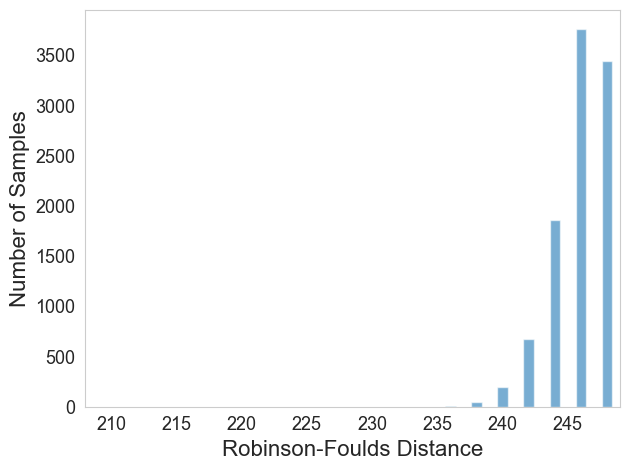

In [136]:
def plot_comparative_histograms(data1, data2, xlabel, ylabel, label1, label2, bins=45, alpha=0.6):
    data1 = np.array(data1)
    data2 = np.array(data2)

    # bins = np.linspace(0, 1, bins + 1)
    # vals = np.arange(data1.min(), data1.max() + 2)
    # plt.hist(data1, alpha=alpha, label=label1, edgecolor='none', bins=vals) #bins=bins
    # plt.hist(data2, bins=bins, alpha=alpha, label=label2, edgecolor='none')
    unique, counts = np.unique(data1, return_counts=True)
    plt.bar(unique, counts, alpha=alpha, label=label1)

    plt.grid(False)
    plt.xlabel(xlabel, fontsize=16)
    plt.ylabel(ylabel, fontsize=16)
    plt.xticks(fontsize=13)
    plt.yticks(fontsize=13)
    # plt.legend(fontsize=13)
    plt.xlim(data1.max()-40, data1.max()+1)
    plt.tight_layout()
    plt.savefig(rf"D:\PhD\figures\paper\Supplementary\{xlabel}_mm34_pairwise_comparison.svg")
    plt.show()


# plot_comparative_histograms(path_len_distances_bootstrap, path_len_distances_random, "Path Length", "Frequency", "Bootstrap", "Random")
plot_comparative_histograms(rf_distances_bootstrap, rf_distances_random, "Robinson-Foulds Distance", "Number of Samples", "Bootstrap", "Random")
# plot_comparative_histograms(vaf_differences_bootstrap, vaf_differences_random, "VAF Difference", "Frequency", "Bootstrap", "Random")

In [5]:
base_path = r"D:\PhD\SCITERNA\simulated_data\50c500m\sciterna_bootstrapping"
n_bootstrap = 1000
n_round = 1
n_c, n_m = 50, 500
path_lengths_consensus = np.zeros((n_c, n_c))

for t in range(n_bootstrap):
    print(t)

    sciterna_parent_vec = np.loadtxt(os.path.join(base_path, "sciterna_parent_vec", f"sciterna_parent_vec_{n_round}r{t}.txt"), dtype=int)

    ct_sciterna = CellTree(n_c, flipped_mutation_direction=True)

    ct_sciterna.use_parent_vec(sciterna_parent_vec)

    dist = leaf_dist_mat(ct_sciterna)
    path_lengths_consensus += dist/n_bootstrap

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [6]:
sciterna_parent_vec = np.loadtxt(os.path.join(r"D:\PhD\SCITERNA\simulated_data\50c500m\parent_vec\parent_vec_0.txt"), dtype=int)

ct_sciterna = CellTree(n_c, flipped_mutation_direction=True)

ct_sciterna.use_parent_vec(sciterna_parent_vec)

path_lengths_consensus = leaf_dist_mat(ct_sciterna)

In [7]:
import numpy as np
from scipy.cluster.hierarchy import linkage, dendrogram, cut_tree

# path_lengths_consensus: (n_c x n_c) numpy array
# clones: number of clusters

# Convert distance matrix to condensed form
from scipy.spatial.distance import squareform
dist_condensed = squareform(path_lengths_consensus)

# Perform Ward hierarchical clustering
Z = linkage(dist_condensed, method='ward')


# --- Build parent vector from merge matrix (Z) ---

def merge_to_parent(Z):
    """
    Convert SciPy linkage matrix to a parent vector.
    For n leaves, Z has shape (n-1, 4) describing merges.
    Return size (2*n-1) parent list, where parent[i] = parent of node i.
    Leaves: 0..n-1
    Internal nodes: n..2n-2
    """
    n = Z.shape[0] + 1
    parent = [-1] * (2 * n - 1)

    for i in range(n-1):
        left = int(Z[i,0])
        right = int(Z[i,1])
        parent[left] = n + i
        parent[right] = n + i

    return parent

parent_vec = merge_to_parent(Z)

In [8]:
sciterna_parent_vec1 = np.loadtxt(os.path.join(r"D:\PhD\SCITERNA\simulated_data\50c500m\parent_vec\parent_vec_0.txt"), dtype=int)

ct_sciterna1 = CellTree(n_c, flipped_mutation_direction=True)
ct_sciterna2 = CellTree(n_c, flipped_mutation_direction=True)

ct_sciterna1.use_parent_vec(sciterna_parent_vec1)
ct_sciterna2.use_parent_vec(parent_vec)


print(path_len_dist(ct_sciterna1, ct_sciterna2))

2.950204081632653


<Axes: >

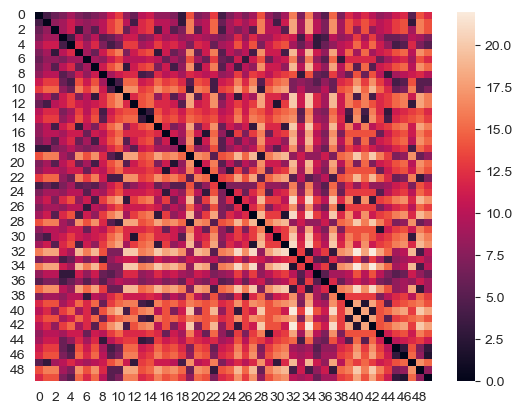

In [9]:
sns.heatmap(path_lengths_consensus)

In [117]:
np.unique(rf_distances_bootstrap)

array([234, 238, 240, 242, 244, 246, 248])

In [89]:
from collections import Counter
from dendropy import Tree, TreeList, TaxonNamespace

def normalize_split(split):
    A, B = map(set, split)

    # Remove trivial splits (less than 2 leaves on either side)
    if len(A) < 2 or len(B) < 2:
        return None

    # Create frozensets for each side
    side1 = frozenset(A)
    side2 = frozenset(B)

    # Return a canonical bipartition as frozenset of frozensets (order insensitive)
    return frozenset([side1, side2])

def get_splits(ct, node, labels=None):
    splits = []
    for child in ct.dfs(node):
        if ct.isleaf(child):
            continue

        child_leaves = [leaf for leaf in ct.leaves(child)]
        other_partition = [leaf for leaf in labels if leaf not in child_leaves]

        if 0 < len(child_leaves) < len(labels):
            splits.append((child_leaves, other_partition))

    return splits

model = "sciterna"
path = r"D:\PhD\SCITERNA\results\mm34"
path = r"D:\PhD\SCITERNA\simulated_data\50c500m\sciterna_bootstrapping"

taxa = TaxonNamespace()
trees = TreeList(taxon_namespace=taxa)
split_counter = Counter()
round=1
for test in range(1000):
    path_parent = os.path.join(path, f"{model}_parent_vec", f"{model}_parent_vec_{round}r{test}.txt")

    if not os.path.exists(path_parent):
        continue

    parent_vec = np.loadtxt(path_parent, dtype=int)

    n_cells = int(((len(parent_vec) + 1) / 2))

    ct = CellTree(n_cells=n_cells)
    ct.use_parent_vec(parent_vec)

    newick_str = to_newick(ct, ct.main_root) + ";"
    tree = Tree.get(data=newick_str, schema="newick", taxon_namespace=taxa)
    trees.append(tree)

    # Count normalized splits
    labels = list(ct.leaves(ct.main_root))
    raw_splits = get_splits(ct, ct.main_root, labels)
    for split in raw_splits:
        norm = normalize_split(split)
        if norm is not None:
            split_counter[norm] += 1

Total trees: 1000
Top 15 splits (split : count / percent):

 1. {34,37} | {0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,35,36,38,39,40,41,42,43,44,45,46,47,48,49}  :  715 / 71.50%
 2. {39,41} | {0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,40,42,43,44,45,46,47,48,49}  :  539 / 53.90%
 3. {22,32,34,37,48} | {0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,23,24,25,26,27,28,29,30,31,33,35,36,38,39,40,41,42,43,44,45,46,47,49}  :  513 / 51.30%
 4. {32,34,37} | {0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,33,35,36,38,39,40,41,42,43,44,45,46,47,48,49}  :  495 / 49.50%
 5. {45,46} | {0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,47,48,49}  :  489 / 48.90%
 6. {38,43} | {0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,3

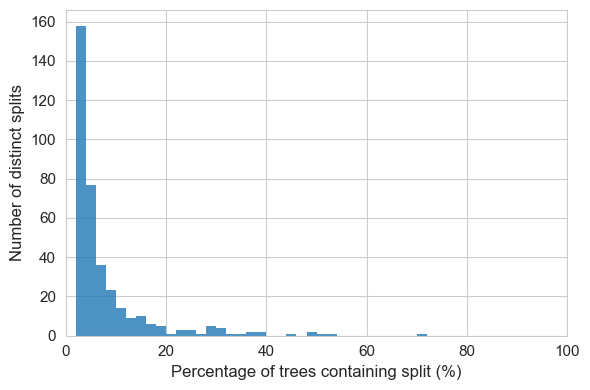

In [90]:
def split_to_label(split):
    # convert frozenset of frozensets to a sorted, readable tuple of comma-joined labels
    sides = [sorted(list(s)) for s in split]
    side_strs = ["{" + ",".join(map(str, s)) + "}" for s in sorted(sides, key=lambda x: (len(x), x))]
    return " | ".join(side_strs)

def summarize_and_plot_splits(split_counter, n_trees, top_n=10, hist_bins=50,
                              hist_outpath=r"D:\PhD\figures\paper\Supplementary\split_percentages_hist.pdf"):
    """
    split_counter : Counter mapping normalized split (frozenset of frozensets) -> count
    n_trees       : total number of trees considered (int)
    top_n         : how many top splits to print
    hist_bins     : number of histogram bins (will be spaced 0..100)
    hist_outpath  : where to save histogram PDF
    """
    if n_trees == 0:
        raise ValueError("n_trees must be > 0")

    # Compute percentages
    split_items = []
    for split, cnt in split_counter.items():
        pct = 100.0 * cnt / n_trees
        split_items.append((split, cnt, pct))

    # Sort by count descending
    split_items.sort(key=lambda x: x[1], reverse=True)

    # Print top splits
    print(f"Total trees: {n_trees}")
    print(f"Top {top_n} splits (split : count / percent):\n")
    for i, (split, cnt, pct) in enumerate(split_items[:top_n], start=1):
        print(f"{i:2d}. {split_to_label(split)}  :  {cnt} / {pct:.2f}%")

    # Prepare list of all percentages for histogram
    percentages = np.array([pct for (_, _, pct) in split_items])

    filtered_percentages = percentages[percentages > 2]

    # Plot histogram using filtered values only
    bins = np.linspace(0, 100, hist_bins + 1)
    plt.figure(figsize=(6,4))
    plt.hist(filtered_percentages, bins=bins, alpha=0.8, edgecolor='none')
    plt.xlabel("Percentage of trees containing split (%)", fontsize=12)
    plt.ylabel("Number of distinct splits", fontsize=12)
    plt.xticks(fontsize=11)
    plt.yticks(fontsize=11)
    plt.xlim(0, 100)
    plt.tight_layout()
    # plt.savefig(hist_outpath)
    plt.show()

    return split_items, percentages

# Example usage (run after your loop that populates split_counter and trees):
n_trees = len(trees)   # or whatever the actual number of trees considered
top_splits, split_percentages = summarize_and_plot_splits(split_counter, n_trees, top_n=15,
                                                          hist_bins=50,
                                                          hist_outpath=r"D:\PhD\figures\paper\Supplementary\split_percentages_hist.pdf")

Total trees: 1000
Top 15 splits (split : count / percent):

 1. {24,44} | {0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,45}  :  880 / 88.00%
 2. {24,32,44} | {0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,25,26,27,28,29,30,31,33,34,35,36,37,38,39,40,41,42,43,45}  :  773 / 77.30%
 3. {29,40} | {0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,30,31,32,33,34,35,36,37,38,39,41,42,43,44,45}  :  685 / 68.50%
 4. {38,41,43} | {0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,39,40,42,44,45}  :  369 / 36.90%
 5. {38,43} | {0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,39,40,41,42,44,45}  :  333 / 33.30%
 6. {6,13} | {0,1,2,3,4,5,7,8,9,10,11,12,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45}  :  275 / 27.50%
 7. {24,25,30,32,34,35,37,38,39,41,43,44,45} | {0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,26,27,28,29,31,33,36,40,42}  :  247 / 24.70%
 8. {26,27} | {0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45}  :  217 / 21.70%
 9. {23,24,25,30,32,34,35,37,38,39,41,43,44,45} | {0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,26,27,28,29,31,33,36,40,42}  :  184 / 18.40%
10. {1,18} | {0,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45}  :  184 / 18.40%
11. {29,40,42} | {0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,30,31,32,33,34,35,36,37,38,39,41,43,44,45}  :  174 / 17.40%
12. {10,15} | {0,1,2,3,4,5,6,7,8,9,11,12,13,14,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45}  :  173 / 17.30%
13. {5,29,40,42} | {0,1,2,3,4,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,30,31,32,33,34,35,36,37,38,39,41,43,44,45}  :  172 / 17.20%
14. {5,42} | {0,1,2,3,4,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,43,44,45}  :  165 / 16.50%
15. {26,31} | {0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,27,28,29,30,32,33,34,35,36,37,38,39,40,41,42,43,44,45}  :  164 / 16.40%

MM34
Total trees: 829
Top 15 splits (split : count / percent):

 1. {33,49} | {0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126}  :  415 / 50.06%
 2. {52,56} | {0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,53,54,55,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126}  :  125 / 15.08%
 3. {24,59} | {0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126}  :  119 / 14.35%
 4. {12,41} | {0,1,2,3,4,5,6,7,8,9,10,11,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126}  :  105 / 12.67%
 5. {28,52} | {0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126}  :  105 / 12.67%
 6. {79,106} | {0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126}  :  105 / 12.67%
 7. {31,51} | {0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126}  :  105 / 12.67%
 8. {6,30} | {0,1,2,3,4,5,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126}  :  102 / 12.30%
 9. {47,55} | {0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,48,49,50,51,52,53,54,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126}  :  99 / 11.94%
10. {37,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126} | {0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64}  :  85 / 10.25%
11. {47,57} | {0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,48,49,50,51,52,53,54,55,56,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126}  :  84 / 10.13%
12. {13,57} | {0,1,2,3,4,5,6,7,8,9,10,11,12,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126}  :  83 / 10.01%
13. {1,44} | {0,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126}  :  82 / 9.89%
14. {112,120} | {0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,113,114,115,116,117,118,119,121,122,123,124,125,126}  :  81 / 9.77%
15. {65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126} | {0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64}  :  79 / 9.53%

Total trees: 1000
Top 15 splits (split : count / percent):

 1. {34,37} | {0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,35,36,38,39,40,41,42,43,44,45,46,47,48,49}  :  715 / 71.50%
 2. {39,41} | {0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,40,42,43,44,45,46,47,48,49}  :  539 / 53.90%
 3. {22,32,34,37,48} | {0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,23,24,25,26,27,28,29,30,31,33,35,36,38,39,40,41,42,43,44,45,46,47,49}  :  513 / 51.30%
 4. {32,34,37} | {0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,33,35,36,38,39,40,41,42,43,44,45,46,47,48,49}  :  495 / 49.50%
 5. {45,46} | {0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,47,48,49}  :  489 / 48.90%
 6. {38,43} | {0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,39,40,41,42,44,45,46,47,48,49}  :  442 / 44.20%
 7. {10,19} | {0,1,2,3,4,5,6,7,8,9,11,12,13,14,15,16,17,18,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49}  :  389 / 38.90%
 8. {32,34,37,48} | {0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,33,35,36,38,39,40,41,42,43,44,45,46,47,49}  :  382 / 38.20%
 9. {12,30} | {0,1,2,3,4,5,6,7,8,9,10,11,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49}  :  378 / 37.80%
10. {0,18,47} | {1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,48,49}  :  363 / 36.30%
11. {24,29} | {0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,25,26,27,28,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49}  :  342 / 34.20%
12. {5,42} | {0,1,2,3,4,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,43,44,45,46,47,48,49}  :  338 / 33.80%
13. {15,27,31} | {0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,16,17,18,19,20,21,22,23,24,25,26,28,29,30,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49}  :  311 / 31.10%
14. {4,9,10,19,22,28,32,34,35,37,45,46,48,49} | {0,1,2,3,5,6,7,8,11,12,13,14,15,16,17,18,20,21,23,24,25,26,27,29,30,31,33,36,38,39,40,41,42,43,44,47}  :  307 / 30.70%
15. {4,9,10,19,22,28,32,34,37,45,46,48,49} | {0,1,2,3,5,6,7,8,11,12,13,14,15,16,17,18,20,21,23,24,25,26,27,29,30,31,33,35,36,38,39,40,41,42,43,44,47}  :  307 / 30.70%